In [1]:
import pandas as pd

# -----------------------
# Scikit-learn
# -----------------------
import sklearn
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    pairwise_distances,
    precision_score,
    recall_score,
    roc_auc_score,
    silhouette_score,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, scale
from sklearn.svm import SVC, OneClassSVM
from sklearn.utils import shuffle, resample 

# -----------------------
# PennyLane (Quantum ML)
# -----------------------
import pennylane as qml
import pennylane.numpy as pnp
from pennylane.kernels import kernel_matrix, square_kernel_matrix
from pennylane.optimize import NesterovMomentumOptimizer


#-------------------
# Jax
# ------------------


import jax
import jax.numpy as jnp


In [7]:
RS = 42

In [2]:
# Get Data 
data = pd.read_csv("PCA_fiber.csv")
data


,Unnamed: 0,region_code_Downtown,region_code_East,region_code_Industrial,region_code_North,region_code_South,region_code_Suburban,region_code_West,link_type_Access,link_type_Aggregation,...,traffic_period_evening,traffic_period_morning,traffic_period_overnight,latency_ms,latency_jitter_ms,packet_loss_pct,error_rate,reset_count,throughput_util_pct,maintenance_flag
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,11.324225,2.106861,0.118247,0.000077,0,45.960570,0
1,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,8.632439,2.030257,0.000000,0.000000,0,37.190357,0
2,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,14.679951,0.721178,0.077039,0.000000,0,67.903547,0
3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,13.848729,0.244006,0.045327,0.000228,0,58.770968,0
4,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,11.249959,0.721537,0.095630,0.000000,0,58.467407,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,14.786192,2.050643,0.111415,0.000319,0,65.639345,0
1996,1996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,19.480694,2.016740,0.129603,0.000110,0,73.860781,0
1997,1997,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,20.355287,3.688590,0.156655,0.000042,0,74.385135,0
1998,1998,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,9.132292,0.050000,0.075876,0.000220,1,50.523288,0


In [3]:
features = data.drop(["maintenance_flag", "Unnamed: 0"], axis=1)
label = data["maintenance_flag"]
label_array = label.to_numpy()

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Jax Test

In [23]:
# PCA
pca = PCA(n_components=8, random_state=RS)
t1 = pca.fit_transform(features)

In [15]:
t1.shape

(2000, 2)

In [24]:
# Downsample Train Test Split
x_down1, y_down1 = resample(t1, label_array, n_samples=800, replace=False, random_state=RS)
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_down1, y_down1, test_size = .3, stratify=y_down1, random_state=RS)

print(x_train_1.shape)
print(x_train_1[0].shape)

(560, 8)
(8,)


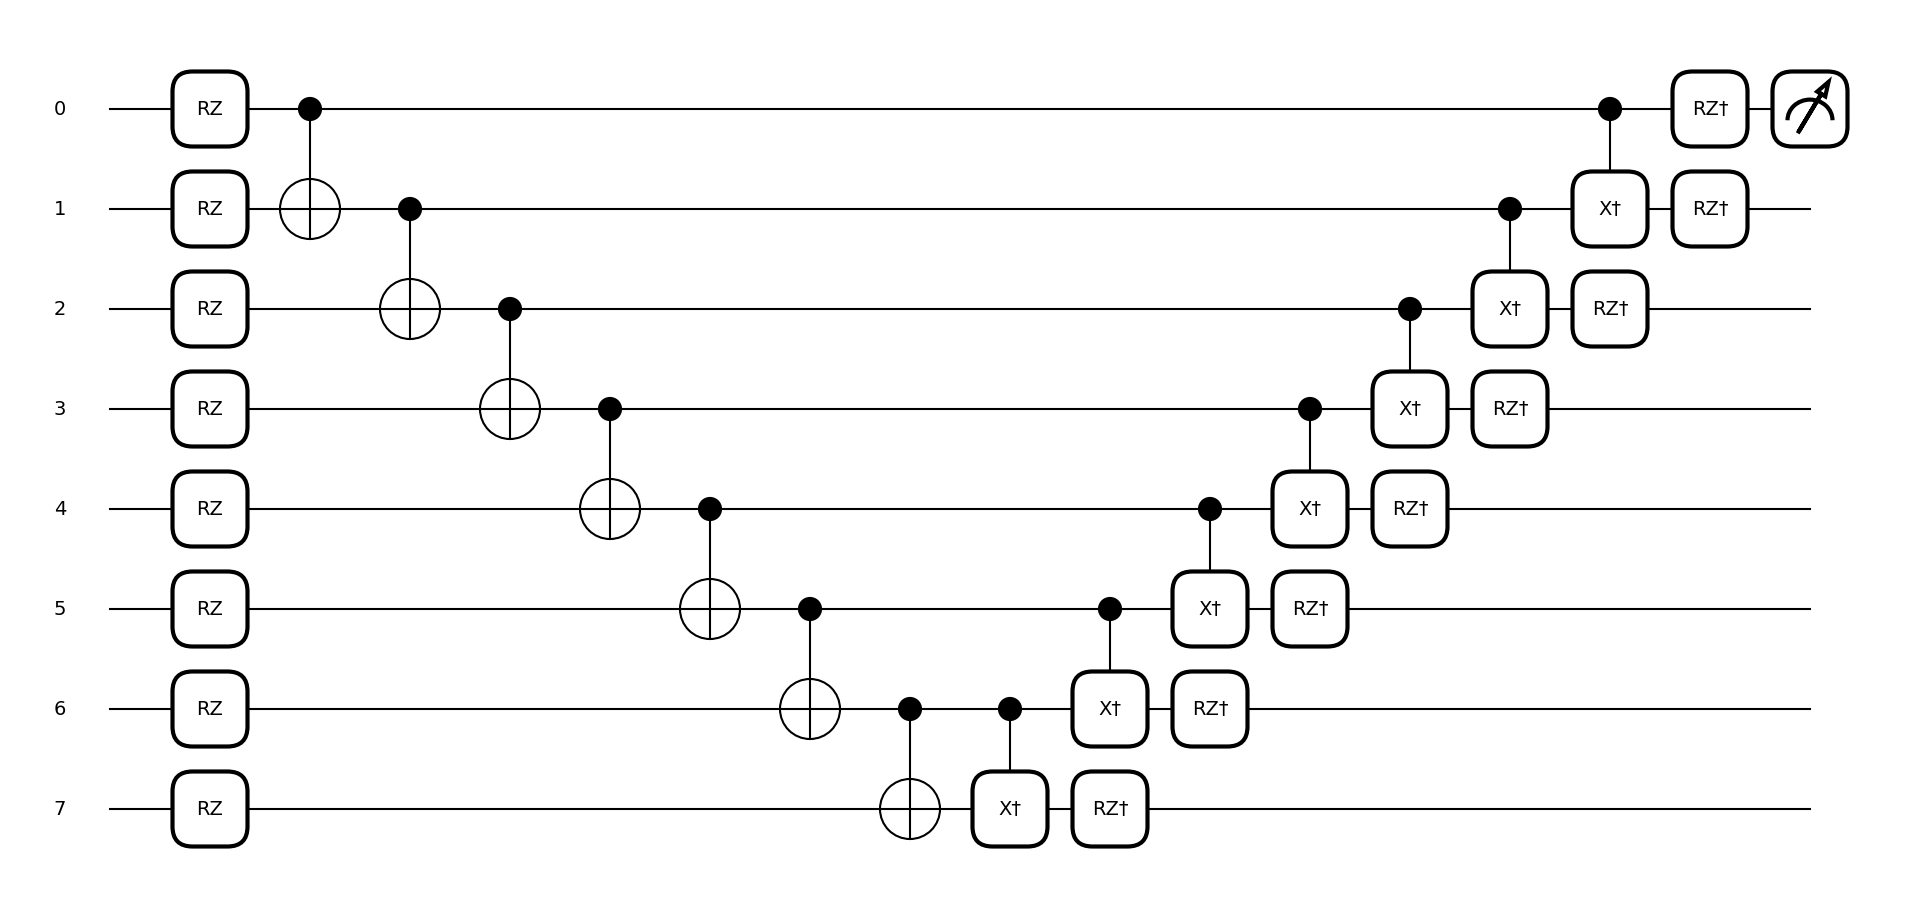

In [49]:
# Full Loop For Viz
import pennylane as qml
import matplotlib.pyplot as plt

n_qubits = x_train_1.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

# --- Pauli-Z feature map ---
def pauli_z_feature_map(x):
    # Apply each RZ individually
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    # CNOT chain
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])


# --- QNode for visualization ---
@qml.qnode(dev)
def full_qsvm_circuit(x1, x2):
    # Apply feature map to x1
    pauli_z_feature_map(x1)
    # Apply adjoint to x2
    qml.adjoint(pauli_z_feature_map)(x2)
    # Return a placeholder observable
    return qml.expval(qml.PauliZ(0))

# Symbolic inputs
x1_sym = [f"x1_{i}" for i in range(n_qubits)]
x2_sym = [f"x2_{i}" for i in range(n_qubits)]

# Draw the full circuit
drawer_mpl = qml.draw_mpl(full_qsvm_circuit)
drawer_mpl(x1_sym, x2_sym)
plt.show()


In [52]:
# Vectorized Approach for calc
import pennylane as qml
import numpy as np

n_qubits = x_train_1.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

def pauli_z_feature_map(x):
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])


# Encode features
@qml.qnode(dev)
def state_circuit(x):
    pauli_z_feature_map(x)
    return qml.state()  # returns full state vector

# Kernel = squared overlap
def quantum_kernel_fast(x1, x2):
    psi1 = state_circuit(x1)
    psi2 = state_circuit(x2)
    return np.abs(np.vdot(psi1, psi2))**2


In [53]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel_fast)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel_fast)

KeyboardInterrupt: 

In [ ]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

ROC AUC: 0.3878346323280244
PR AUC: 0.04463231035871392
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Accuracy: 0.9458333333333333


c:\Users\otmas\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:
#Batched verison
import pennylane as qml
import numpy as np

n_qubits = x_train_1.shape[1]
dev = qml.device("lightning.qubit", wires=n_qubits)

def pauli_z_feature_map(x):
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])


# Encode features
@qml.batch_transform(dev,batch_arg="x", batch_size=8)
def state_circuit(x):
    pauli_z_feature_map(x)
    return qml.state()  # returns full state vector

# Kernel = squared overlap
def quantum_kernel_fast(x1, x2):
    # X1 and X2 are 2D arrays (shape: [N, n_qubits])
    # Returns kernel matrix of shape [N, N]
    
    # Compute all states in one call (batch_size auto-detected)
    psi1s = state_circuit(x1)  # Array of state vectors
    psi2s = state_circuit(x2)  # Array of state vectors
    
    # Compute all pairwise overlaps (K[i,j] = <psi1_i|psi2_j>)
    K = np.abs(np.einsum('ij,kj->ik', psi1s, np.conj(psi2s)))**2
    return K


In [ ]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel_fast)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel_fast)

In [ ]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

In [ ]:
dev = qml.device("lightning.qubit", wires=n_qubits)

def pauli_z_feature_map(x):
    for i in range(n_qubits):
        qml.RZ(x[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i+1])

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    # Prepare |ψ(x1)>
    pauli_z_feature_map(x1)
    
    # Note: We need to somehow "append" x2's circuit in reverse (conjugate)
    # BUT: Instead, we use destructive interference.
    qml.adjoint(pauli_z_feature_map)(x2)  # Apply conjugate
    
    # Measure overlap as probability of |0...0> state
    return qml.probs(wires=range(n_qubits))  # Measures P(0...0) = |<ψ(x1)|ψ(x2)>|²

# Now compute overlap directly without storing states
def quantum_kernel_fast(x1, x2):
    prob_0 = kernel_circuit(x1, x2)[0]  # P(0...0) = |<ψ(x1)|ψ(x2)>|²
    return prob_0.item()  # scalar

In [ ]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel_fast)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel_fast)

In [ ]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

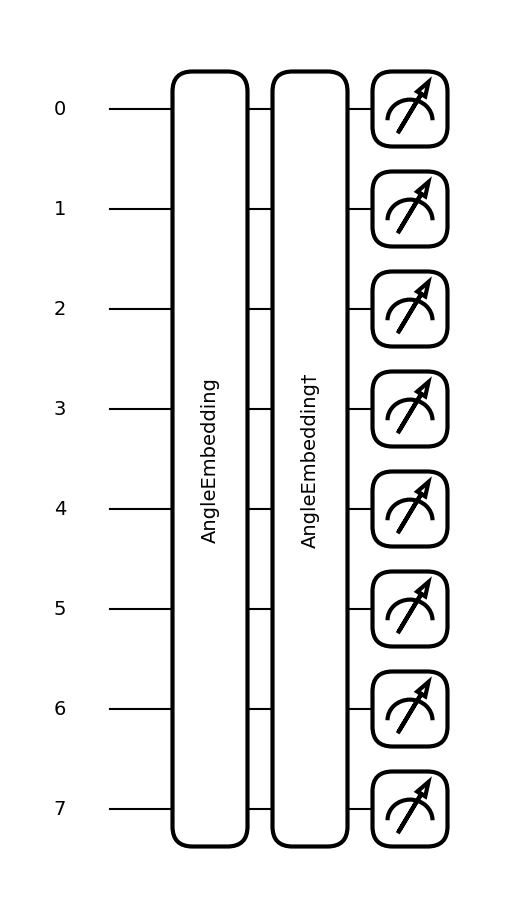

In [36]:
# Initalize Circuit 

# Create Qubits
n_qubits = x_train_1.shape[1] # Select qubits = to the number of columns
dev = qml.device("lightning.qubit", wires=n_qubits) # We are simulating a quantum system with pennylanes default

# Angle Encoding Circut
@qml.qnode(dev)
def circuit(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(n_qubits)) # template that applies rotation around y axis by default!
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(n_qubits)) # calculates the hermitian adjoint (inverse)
    return qml.probs(wires=range(n_qubits))



# Create Kernel Funnction with quantum circut
def quantum_kernel(x1, x2):
    return circuit(x1, x2)[0]


import matplotlib.pyplot as plt
import pennylane as qml

# Assume you already have your QNode `circuit` defined

# Use symbolic inputs for clean diagram
x1_sym = [f"x1_{i}" for i in range(n_qubits)]
x2_sym = [f"x2_{i}" for i in range(n_qubits)]

# Draw with matplotlib
drawer_mpl = qml.draw_mpl(circuit)
drawer_mpl(x1_sym, x2_sym)

# Show plot
plt.show()


In [ ]:
PCA_kernel_train = square_kernel_matrix(x_train_1, kernel=quantum_kernel)
PCA_kernel_test = kernel_matrix(x_test_1, x_train_1, kernel=quantum_kernel)

In [ ]:
# Train the SVM
clf1 = SVC(kernel='precomputed', class_weight='balanced')
clf1.fit(PCA_kernel_train, y_train_1)

y_pred = clf1.predict(PCA_kernel_test)

# Metrics
y_scores = clf1.decision_function(PCA_kernel_test)
roc_auc = roc_auc_score(y_test_1, y_scores)
pr_auc = average_precision_score(y_test_1, y_scores)
precision = precision_score(y_test_1, y_pred, average='binary')
recall = recall_score(y_test_1, y_pred, average='binary')
f1 = f1_score(y_test_1, y_pred, average='binary')
accuracy = accuracy_score(y_test_1, y_pred)

print("ROC AUC:", roc_auc)
print("PR AUC:", pr_auc)


print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")